# Projeto 02 - Sepsis Detection

### Introdução

A sepse ocorre quando substâncias químicas liberadas na corrente sanguínea para combater uma infecção desencadeiam uma inflamação em todo o corpo. Isso pode causar uma série de alterações que danificam diversos sistemas de órgãos, levando-os a falhar e, às vezes, resultando em morte.

https://www.einstein.br/doencas-sintomas/sepse-hemodinamica

### Objetivo
O grande problema com o diagnóstico preciso de sepse é que ele envolve a obtenção de amostras de sangue e urina do paciente, e até que sejam aferidas às quantidades relativas de lactato, leucócitos e proteína C reativa ou feita a cultura de urina, que são indicadores mais precisos de sepse, o paciente pode apresentar uma piora exponencial no seu quadro clínico.

Desta forma, o objetivo é elaborar um alarme “pré-séptico” utilizando aprendizado de máquina somente nos sinais vitais dos pacientes, assim, 
a equipe médica pode priorizar a coleta de sangue e urina destes pacientes.

### Base de Dados
A base para modelagem do alarme "pré-séptico" foi extraída do prontuário de diversos pacientes em 2019 que apresentaram sinais, ou não, de infecção generalizada. Todos os dados foram digitalizados manualmente por funcionários da administração do hospital. O diagnóstico final dos pacientes, para gerar o rótulo de sepse, foi obtido através da análise das medidas do lactato, leucócitos e proteína C reativa, além do casamento dessas medidas com o estado dos sinais vitais do paciente na situação.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
np.random.seed(2021)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Aprendizado de Máquina/training_data_sepse.csv')

# Conhecendo os dados


ID<br>
N° de Atendimento (N° do Paciente)<br>
Temperatura<br>
Pulso<br>
Respiração<br>
Pa_min (Pressão Mínima)<br>
Pa_max (Pressão Máxima)

In [4]:
df_train.head()

,id,num_atend,temperatura,pulso,respiracao,pa_min,pa_max,sepse
0,1,6066066,36.0,117.0,NaN,113.0,72.0,1
1,2,6019916,36.0,105.0,NaN,NaN,NaN,1
2,3,6000000,38.0,118.0,NaN,110.0,70.0,1
3,4,5993343,37.0,136.0,NaN,NaN,NaN,1
4,5,6001799,37.0,104.0,NaN,NaN,NaN,1


Verificando presença de dados faltantes e duplicados

In [5]:
nLinhas , nColunas = df_train.shape

dupl = df_train.duplicated().sum()/nLinhas

print('Porcentagem de linhas duplicadas:', round(dupl*100,2))

Porcentagem de linhas duplicadas: 0.0


Pode ocorrer de uma mesma pessoa ter seus sinais vitais coletados mais de uma vez e isso não caracteriza um erro de base, dado que é esperado que ocorra.

In [6]:
#Verificado a quantidade de NaN por atributo
nan_train= pd.DataFrame()
nan_train['Qtd Nan'] = df_train.isna().sum()
nan_train['Qtd Nan %'] = round(100*df_train.isna().sum()/len(df_train),2)
nan_train.head(6)

,Qtd Nan,Qtd Nan %
id,0,0.00
num_atend,0,0.00
temperatura,2145,12.66
pulso,2736,16.14
respiracao,13734,81.03
pa_min,8466,49.95


In [7]:
#Retirando variaveis que nao sao importantes para a modelagem
df_train.drop(['id', 'num_atend'], axis=1, inplace= True)


Verificando balanceamento da base

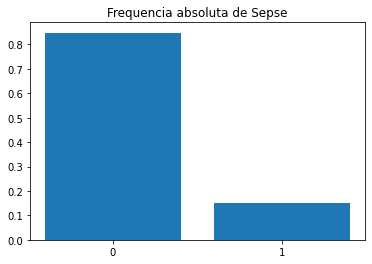

In [8]:
y = df_train.sepse.value_counts()/df_train.sepse.value_counts().sum() #frequencia absoluta
plt.bar(['0','1'],y)
plt.title('Frequencia absoluta de Sepse')
plt.show()

Nota-se pelo gráfico acima que a variável alvo está desbalanceada. Um desbalanceamento da classe ocorre quando existe desproporção entre o número de exemplos de uma ou mais classes em relação ao restante.

Ao usar um modelo de classificação nos dados, o resultado do mesmo seria enviesado. Para evitar que isso ocorra, será utilizada a amostragem estratificada durante a modelagem.


# Pré-processamento

## Tratando o campo temperatura

In [9]:
treino = df_train.copy()

In [10]:
treino.temperatura.unique()

array([  36. ,   38. ,   37. ,   35. ,   32. ,    nan,   39. ,   35.8,
          0. ,   34. ,   36.7,   35.6,  356. ,   40. ,  131. ,   36.8,
         35.1,   36.1,   35.4,   33.6,   37.6,   36.6,   35.5,   36.5,
       3602. ,   37.2,    6. ,  378. ,   36.9,  -35. ,   36.2,   36.3,
         37.7,   33. ,   85. ,  336. ,  368. ,   37.5,   35.3,   35.7,
         35.9,   36.4])

Alguns valores como 336, 378, por exemplo, entende-se que foi algum erro na hora de passar os dados para a planilha. Logo, tais valores serão corrigidos.

In [11]:
treino.temperatura.replace({378.:37.8, 336.:33.6, 368.:36.8, 356.:35.6}, inplace=True)
treino.temperatura.replace(3602., np.nan, inplace=True)

Há temperaturas com valores negativos, dessa forma, será ajustado para serem valores positivos.

In [12]:
treino.temperatura = treino.temperatura.apply(abs)

Temperaturas nulas serão substituídas por NaN

In [13]:
treino.temperatura.replace(0, np.nan, inplace=True)

In [14]:
treino['temperatura'].describe()

count    14607.000000
mean        36.196166
std          1.384627
min          6.000000
25%         36.000000
50%         36.000000
75%         36.700000
max        131.000000
Name: temperatura, dtype: float64

De acordo com o site https://www.medicinanet.com.br/conteudos/revisoes/6263/hipotermia_acidental.htm e https://www.medicinanet.com.br/conteudos/acp-medicine/5945/hipertermia_febre_e_febre_de_origem_indeterminada.htm será classificado que pessoas com temperatura abaixo de 30 graus celsius e acima de 42, já estariam em condições extremamente ruins, dessa forma, já seriam encaminhadas direto à emergência.

Valores no intervalo citado acima serão substituídos por NaN.

In [15]:
treino.query('temperatura < 30 or temperatura > 42')

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
577,131.0,106.0,NaN,NaN,NaN,1
1843,6.0,101.0,NaN,158.0,89.0,0
4451,6.0,87.0,NaN,131.0,80.0,0
7123,85.0,85.0,NaN,NaN,NaN,0
11772,85.0,85.0,NaN,NaN,NaN,0


In [16]:
treino.temperatura.replace(treino['temperatura'].values[treino['temperatura'].values < 30], np.nan, inplace=True)
treino.temperatura.replace(treino['temperatura'].values[treino['temperatura'].values > 42], np.nan, inplace=True)

In [17]:
treino.temperatura.unique()

array([36. , 38. , 37. , 35. , 32. ,  nan, 39. , 35.8, 34. , 36.7, 35.6,
       40. , 36.8, 35.1, 36.1, 35.4, 33.6, 37.6, 36.6, 35.5, 36.5, 37.2,
       37.8, 36.9, 36.2, 36.3, 37.7, 33. , 37.5, 35.3, 35.7, 35.9, 36.4])

In [19]:
treino.temperatura.unique()

array([36. , 38. , 37. , 35. , 32. ,  nan, 39. , 35.8, 34. , 36.7, 35.6,
       40. , 36.8, 35.1, 36.1, 35.4, 33.6, 37.6, 36.6, 35.5, 36.5, 37.2,
       37.8, 36.9, 36.2, 36.3, 37.7, 33. , 37.5, 35.3, 35.7, 35.9, 36.4])

In [20]:
treino.temperatura.describe()

count    14602.000000
mean        36.187125
std          0.922527
min         32.000000
25%         36.000000
50%         36.000000
75%         36.700000
max         40.000000
Name: temperatura, dtype: float64

## Tratando o campo pulso

In [21]:
treino.pulso.unique() #batimento cardiaco

array([ 117.,  105.,  118.,  136.,  104.,   83.,   91.,   99.,   67.,
        116.,  107.,   72.,   85.,   68.,  102.,  110.,   66.,  139.,
         74.,  101.,  120.,   71.,  144.,   nan,   96.,  108.,   92.,
         98.,   94.,  100.,  114.,   78.,   87.,   97.,  106.,  111.,
        115.,  112.,   64.,   90.,  103.,   76.,  124.,   80.,  119.,
        140.,   75.,  137.,   82.,  125.,  134.,  109.,  122.,   79.,
         95.,  121.,  130.,   65.,   69.,  113.,   73.,   77.,  131.,
         88.,   81.,   93.,  126.,   84.,   56.,  128.,  170.,   60.,
         38.,  154.,  123.,  138.,  155.,   86.,  127.,   70.,   52.,
         89.,  132.,  152.,   62.,  135.,   61.,  149.,  179.,  150.,
        183.,   51.,  165.,   63.,  143.,   44.,  129.,  151.,  156.,
        158.,   55.,   59.,  153.,  174.,  186.,   42.,   40.,  145.,
         32.,  133.,   43.,  142.,   54.,  160.,   53.,   58.,   57.,
       1000.,   50.,   46.,  168.,   30.,   47.,   49.,  175.,   11.,
         10.,  166.,

Pacientes com o valor da variável pulso zero terão esse valor substituido por NaN

In [22]:
treino.pulso.replace(0, np.nan, inplace=True)